In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import os
import h5py
from dataclasses import dataclass
from typing import List
import datetime
import scipy.interpolate
from scipy.special import lambertw
import lmfit
from tqdm.notebook import tqdm

In [14]:
@dataclass
class LossSample:
    loss: np.ndarray
    loss_t: np.ndarray
    loss_timestamp: np.ndarray

    intensity: np.ndarray
    intensity_t: np.ndarray
    intensity_timestamp: np.ndarray

    angle: float
    wire: bool
    octupole: bool

In [15]:
def take_from_peak(times, losses):
    peak_index = np.argmax(losses)
    return times[peak_index:], losses[peak_index:]

In [16]:
data_path = "/eos/project-d/da-and-diffusion-studies/Wire_Compensator_Studies/DATA_MD/"

In [17]:
summ_plot_df = pd.read_pickle(data_path+'summary_plot_data.pkl')

In [18]:
summ_plot_df["datetime"] = summ_plot_df.index.to_pydatetime()

In [19]:
summ_plot_df["seconds"] = summ_plot_df["datetime"].apply(
    lambda x: (x - summ_plot_df["datetime"].iloc[0]).total_seconds()
)

In [20]:
# Crossing angle

T0 = summ_plot_df.index[0].to_pydatetime()
T0bis = pd.Timestamp('2018-10-29 11:08:00.000000000+00:00', tz='CET').to_pydatetime()
T1 = pd.Timestamp('2018-10-29 11:43:29.887000084+00:00', tz='CET').to_pydatetime()
T2 = pd.Timestamp('2018-10-29 12:04:57.258000135+00:00', tz='CET').to_pydatetime()
T3 = pd.Timestamp('2018-10-29 12:23:33.439000130+00:00', tz='CET').to_pydatetime()
T3bis = pd.Timestamp('2018-10-29 13:00:33.439000130+00:00', tz='CET').to_pydatetime()
T4 = summ_plot_df.index[-1].to_pydatetime()

/home/camontan/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Discarding nonzero nanoseconds in conversion.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
def classify_angle(t):
    if t < T0bis:
        return -1.0
    if t < T1:
        return 160.0
    elif t < T2:
        return 150.0
    elif t < T3:
        return 140.0
    else:
        return 130.0

In [22]:
def classify_angle_seconds(s):
    if s < (T0bis - T0).total_seconds():
        return -1.0
    if s < (T1 - T0).total_seconds():
        return 160.0
    elif s < (T2 - T0).total_seconds():
        return 150.0
    elif s < (T3 - T0).total_seconds():
        return 140.0
    else:
        return 130.0

In [23]:
summ_plot_df.columns

Index(['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY', 'LHC.BCTDC.A6R4.B2:BEAM_INTENSITY',
       'LHC.BLM.LIFETIME:B1_BEAM_LIFETIME',
       'LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS', 'LHC.BLM.LIFETIME:B1_LOSS_KW',
       'LHC.BLM.LIFETIME:B2_BEAM_LIFETIME',
       'LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS', 'LHC.BLM.LIFETIME:B2_LOSS_KW',
       'LHC.BLM.LIFETIME:LUMINOSITY_LOSS', 'LHC.RUNCONFIG:IP1-XING-V-MURAD',
       'LHC.RUNCONFIG:IP2-XING-V-MURAD', 'LHC.RUNCONFIG:IP5-XING-H-MURAD',
       'LHC.RUNCONFIG:IP8-XING-H-MURAD', 'RPMBB.RR17.ROF.A12B1:I_MEAS',
       'RPMBB.RR17.ROF.A12B2:I_MEAS', 'RPMC.UL14.RBBCW.L1B2:I_MEAS',
       'RPMC.UL16.RBBCW.R1B2:I_MEAS', 'RPMC.UL557.RBBCW.R5B2:I_MEAS',
       'RPMC.USC55.RBBCW.L5B2:I_MEAS', 'datetime', 'seconds'],
      dtype='object')

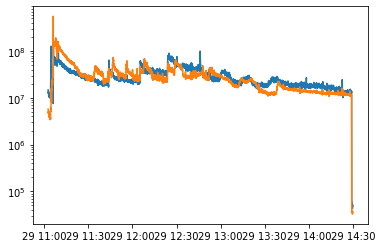

In [24]:
plt.plot(summ_plot_df["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].dropna())
plt.plot(summ_plot_df["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].dropna())

plt.yscale("log")

In [25]:
wire_f = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df["RPMC.UL16.RBBCW.R1B2:I_MEAS"].notna()],
    summ_plot_df["RPMC.UL16.RBBCW.R1B2:I_MEAS"].dropna(),
    bounds_error=False,
    fill_value=0.0
)

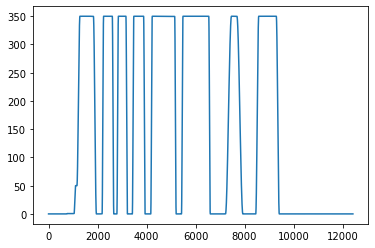

In [26]:
x = np.linspace(summ_plot_df["seconds"].iloc[0], summ_plot_df["seconds"].iloc[-1], 10000)
plt.plot(x, wire_f(x))

In [27]:
intensity_b1 = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notna()],
    summ_plot_df['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna(),
    bounds_error=False,
    fill_value=summ_plot_df['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna().iloc[0]
)

In [28]:
intensity_b2 = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notna()],
    summ_plot_df['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna(),
    bounds_error=False,
    fill_value=summ_plot_df['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna().iloc[0]
)

In [29]:
def classify_wire(x, low_bound=10.0, high_bound=340.0):
    if wire_f(x) < low_bound:
        return 0
    elif wire_f(x) > high_bound:
        return 1
    else:
        return -1

In [30]:
print(wire_f(7000))
classify_wire(7000)

0.011988732130186072


0

In [31]:
octo_f = scipy.interpolate.interp1d(
    summ_plot_df["seconds"][summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].notna()],
    summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna(),
    bounds_error=False,
    fill_value=np.nanmax(summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna())
)

263.65765
-564.9797


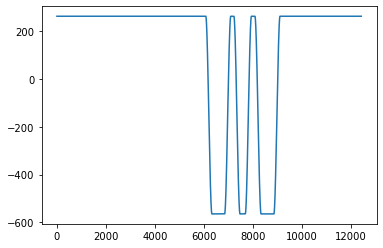

In [32]:
x = np.linspace(summ_plot_df["seconds"].iloc[0], summ_plot_df["seconds"].iloc[-1], 10000)
plt.plot(x, octo_f(x))
print(np.nanmax(summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna()))
print(np.nanmin(summ_plot_df["RPMBB.RR17.ROF.A12B2:I_MEAS"].dropna()))

In [33]:
def classify_octo(x, low_bound=-550.0, high_bound=250.0):
    if octo_f(x) < low_bound:
        return 0
    elif octo_f(x) > high_bound:
        return 1
    else:
        return -1

In [46]:
summ_plot_df["angle"] = summ_plot_df["seconds"].apply(classify_angle_seconds)
summ_plot_df["wire"] = summ_plot_df["seconds"].apply(classify_wire)
summ_plot_df["octupole"] = summ_plot_df["seconds"].apply(classify_octo)

In [35]:
summ_plot_df["angle"]

2018-10-29 11:02:45.519999981+00:00     -1.0
2018-10-29 11:02:45.640000105+00:00     -1.0
2018-10-29 11:02:45.653000116+00:00     -1.0
2018-10-29 11:02:45.660000086+00:00     -1.0
2018-10-29 11:02:45.680000067+00:00     -1.0
                                       ...  
2018-10-29 14:29:46.680000067+00:00    130.0
2018-10-29 14:29:46.858000040+00:00    130.0
2018-10-29 14:29:47+00:00              130.0
2018-10-29 14:29:47.019999981+00:00    130.0
2018-10-29 14:29:47.140000105+00:00    130.0
Name: angle, Length: 149113, dtype: float64

In [48]:
def replace_minus_1(x: np.ndarray):
    x = x.copy()
    for i, v in enumerate(x):
        if v == -1.0:
            if i == 0:
                x[i] = x[i]
            else:
                x[i] = x[i - 1]
    return x

In [49]:
summ_plot_df["angle_contiguos"] = replace_minus_1(summ_plot_df["angle"].to_numpy())
summ_plot_df["wire_contiguos"] = replace_minus_1(summ_plot_df["wire"].to_numpy())
summ_plot_df["octupole_contiguos"] = replace_minus_1(summ_plot_df["octupole"].to_numpy())

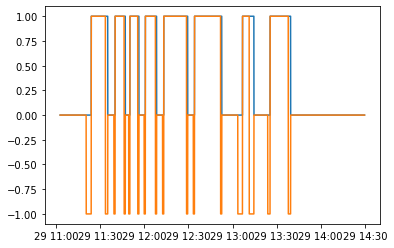

In [50]:
plt.plot(summ_plot_df["wire_contiguos"])
plt.plot(summ_plot_df["wire"])

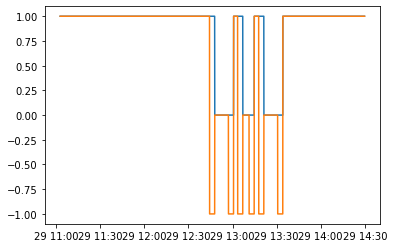

In [51]:
# plt.plot(summ_plot_df["angle"])
# plt.twinx()
plt.plot(summ_plot_df["octupole_contiguos"])
plt.plot(summ_plot_df["octupole"])

In [52]:
selected_columns = summ_plot_df[["angle", "wire", "octupole"]]

In [53]:
cumsum = (selected_columns != selected_columns.shift()).cumsum()
cumsum["sum"] = cumsum.sum(axis=1)
cumsum["sum"]

2018-10-29 11:02:45.519999981+00:00     3
2018-10-29 11:02:45.640000105+00:00     3
2018-10-29 11:02:45.653000116+00:00     3
2018-10-29 11:02:45.660000086+00:00     3
2018-10-29 11:02:45.680000067+00:00     3
                                       ..
2018-10-29 14:29:46.680000067+00:00    51
2018-10-29 14:29:46.858000040+00:00    51
2018-10-29 14:29:47+00:00              51
2018-10-29 14:29:47.019999981+00:00    51
2018-10-29 14:29:47.140000105+00:00    51
Name: sum, Length: 149113, dtype: int64

In [54]:
loss_list_b1 = []
loss_list_b2 = []

for i, g in summ_plot_df.groupby([cumsum["sum"]]):
    if g["octupole"].iloc[0] == -1.0:
        continue
    if g["angle"].iloc[0] == -1.0:
        continue

    loss_list_b1.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle"].dropna().to_numpy()[0],
            wire=False,
            octupole=bool(g["octupole"].dropna().to_numpy()[0])
        )
    )

    if g["wire"].iloc[0] == -1:
        continue

    loss_list_b2.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle"].dropna().to_numpy()[0],
            wire=bool(g["wire"].dropna().to_numpy()[0]),
            octupole=bool(g["octupole"].dropna().to_numpy()[0])
        )
    )

In [63]:
for b in loss_list_b1:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False

In [64]:
for b in loss_list_b2:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupo

In [57]:
selected_columns = summ_plot_df[["angle_contiguos", "wire_contiguos", "octupole_contiguos"]]


In [58]:
cumsum = (selected_columns != selected_columns.shift()).cumsum()
cumsum["sum"] = cumsum.sum(axis=1)
cumsum["sum"]

2018-10-29 11:02:45.519999981+00:00     3
2018-10-29 11:02:45.640000105+00:00     3
2018-10-29 11:02:45.653000116+00:00     3
2018-10-29 11:02:45.660000086+00:00     3
2018-10-29 11:02:45.680000067+00:00     3
                                       ..
2018-10-29 14:29:46.680000067+00:00    29
2018-10-29 14:29:46.858000040+00:00    29
2018-10-29 14:29:47+00:00              29
2018-10-29 14:29:47.019999981+00:00    29
2018-10-29 14:29:47.140000105+00:00    29
Name: sum, Length: 149113, dtype: int64

In [59]:
loss_list_cont_b1 = []
loss_list_cont_b2 = []

for i, g in summ_plot_df.groupby([cumsum["sum"]]):
    if g["octupole_contiguos"].iloc[0] == -1:
        continue
    if g["angle_contiguos"].iloc[0] == -1.0:
        continue

    loss_list_cont_b1.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B1_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B1:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle_contiguos"].dropna().to_numpy()[0],
            wire=False,
            octupole=bool(g["octupole_contiguos"].dropna().to_numpy()[0])
        )
    )

    if g["wire_contiguos"].iloc[0] == -1:
        continue

    loss_list_cont_b2.append(
        LossSample(
            loss=g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].dropna().to_numpy(),
            loss_t=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["seconds"].to_numpy(),
            loss_timestamp=g[g["LHC.BLM.LIFETIME:B2_CALIBRATED_LOSS"].notnull()]["datetime"].to_numpy(),

            intensity=g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].dropna().to_numpy(),
            intensity_t=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["seconds"].to_numpy(),
            intensity_timestamp=g[g['LHC.BCTDC.A6R4.B2:BEAM_INTENSITY'].notnull()]["datetime"].to_numpy(),

            angle=g["angle_contiguos"].dropna().to_numpy()[0],
            wire=bool(g["wire_contiguos"].dropna().to_numpy()[0]),
            octupole=bool(g["octupole_contiguos"].dropna().to_numpy()[0])
        )
    )

In [65]:
for b in loss_list_cont_b1:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: 

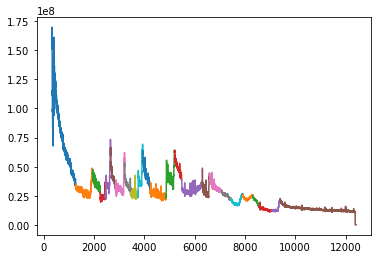

In [68]:
for b in loss_list_cont_b2:
    plt.plot(b.loss_t, b.loss, label=str(b.angle))

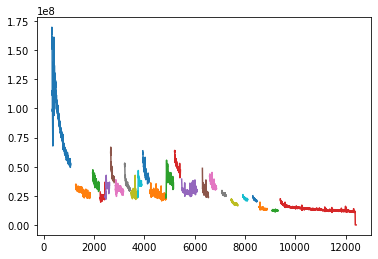

In [69]:
for b in loss_list_b2:
    plt.plot(b.loss_t, b.loss, label=str(b.angle))

In [ ]:
for b in loss_list_cont_b2:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: True 	octupo

In [70]:
TURNS_PER_SECOND = 11245.0

In [31]:
from scipy.special import lambertw

In [32]:
def relative_wrap(n, d_func, **kwargs):
    return 1 - (1 + np.power(d_func(n, **kwargs), 2)) * np.exp(-np.power(d_func(n, **kwargs), 2))


In [33]:
def model_2(n, rho, kappa):
    return rho * np.power(kappa / (2 * np.exp(1)), kappa) * np.power(1 / np.log(n), kappa)

def wrap_2(n, rho, kappa):
    return relative_wrap(n, model_2, rho=rho, kappa=kappa)

def wrap_2_d(n, rho, kappa):
    return 2*kappa*rho**2*(kappa*np.exp(-1)/2)**(2*kappa)*(-rho**2*(kappa*np.exp(-1)/2)**(2*kappa)/np.log(n)**(2*kappa) - 1)*np.exp(-rho**2*(kappa*np.exp(-1)/2)**(2*kappa)/np.log(n)**(2*kappa)) / \
        (n*np.log(n)*np.log(n)**(2*kappa)) + 2*kappa*rho**2*(kappa*np.exp(-1)/2)**(2*kappa) * \
        np.exp(-rho**2*(kappa*np.exp(-1)/2)**(2*kappa)/np.log(n)
               ** (2*kappa))/(n*np.log(n)*np.log(n)**(2*kappa))

In [34]:
def model_4(n, rho, kappa):
    return rho * np.power(
        -np.exp(1) * lambertw(
            -(1 / (np.exp(1))) * np.power(rho / 6, 1 / kappa) * np.power(n * 8 / 7, -2/kappa),
            -1
        ),
        -kappa)

def wrap_4(n, rho, kappa):
    return relative_wrap(n, model_4, rho=rho, kappa=kappa)

def wrap_4_d(n, rho, kappa):
    result = -4*rho**2*(-rho**2/(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa) - 1)*np.exp(-rho**2/(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa))/(n*(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa)*(lambertw(-(rho/6) ** (1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1) + 1)) - 4*rho**2*np.exp(-rho**2/(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa))/(n*(-np.exp(1)*lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1))**(2*kappa)*(lambertw(-(rho/6)**(1/kappa)*np.exp(-1)/(8*n/7)**(2/kappa), -1) + 1))
    return result.real

In [35]:
def resid(params, x, y, model="model_4"):
    rho = params['rho'].value
    kappa = params['kappa'].value
    a = params['a'].value
    if model == "model_4":
        model = wrap_4_d(x + a, rho, kappa)
    elif model == "model_2":
        model = wrap_2_d(x + a, rho, kappa)
    else:
        raise ValueError("Model not recognized")
    # keep real part of model only
    model = model.real
    if np.isnan(model).any():
        print(rho, kappa, a)
        return y + 1e10
    return y + model

In [36]:
def fit_data(seconds, loss, intensity, n0=2, vary_a=False, method="leastsq", rho0=100.0, kappa0=0.75):
    # init parameters for lmfit
    params = lmfit.Parameters()
    params.add('rho', value=rho0, min=0)
    params.add('kappa', value=kappa0, min=0.01)
    params.add('a', value=0, vary=vary_a, min=0)

    # prepare the loss data
    turns = seconds * TURNS_PER_SECOND
    y = (loss / intensity) / TURNS_PER_SECOND

    # set the offset
    turns -= turns[0]
    turns += n0

    # fit the data
    result = lmfit.minimize(resid, params, args=(turns, y), method=method)
    return result, turns, y

In [37]:
best_fits_b1 = pd.DataFrame(
    columns=["angle", "rho", "kappa", "n0", "chisq"]
)
best_fits_b1

,angle,rho,kappa,n0,chisq


In [71]:
import pickle

In [72]:
with open("loss_list_b2.pkl", "wb") as f:
    pickle.dump(loss_list_b2, f)

with open("loss_list_cont_b2.pkl", "wb") as f:
    pickle.dump(loss_list_cont_b2, f)

In [39]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==160.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_160.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)

In [40]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==150.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_150.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)


In [41]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==140.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_140.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)


In [42]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==130.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

with open("b1_130.pkl", 'wb') as f:
    pickle.dump((t * TURNS_PER_SECOND, loss / TURNS_PER_SECOND, intensity), f)


In [114]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==160.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

intensity = intensity_b1(t[0])

In [39]:
result_list = []
n0_values = np.logspace(1, 8, 36) 

for n0 in tqdm(n0_values):
    try:
        result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
        result_list.append((result, turns, y))
    except Exception as e:
        print("Failed to fit data for n0 = {}".format(n0))
        result_list.append((None, None, None))

  0%|          | 0/36 [00:00<?, ?it/s]

330.42478319865893 0.014995598264292864 0


KeyboardInterrupt: 

In [ ]:
chi_sqr_list = []
for r in result_list:
    chi_sqr_list.append(r[0].chisqr)

best_idx = np.argmin(chi_sqr_list)

In [ ]:
best_fits_b1 = best_fits_b1.append({
    "angle": 160.0,
    "rho": result_list[best_idx][0].params['rho'].value,
    "kappa": result_list[best_idx][0].params['kappa'].value,
    "n0": n0_values[best_idx],
    "chisq": chi_sqr_list[best_idx]
}, ignore_index=True)
    

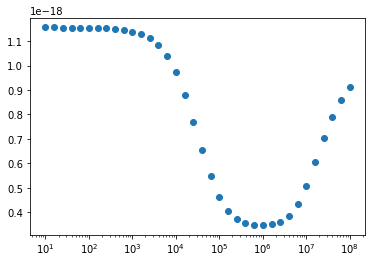

In [ ]:
plt.scatter(n0_values, chi_sqr_list)
plt.xscale("log")

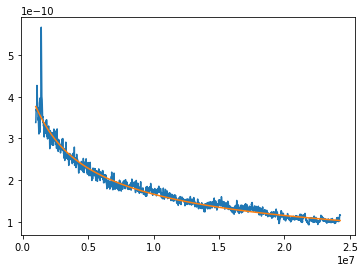

In [ ]:
plt.plot(result_list[best_idx][1], result_list[best_idx][2], label="data")
plt.plot(result_list[best_idx][1], result_list[best_idx][2] - result_list[best_idx][0].residual, label="residual")

In [ ]:
t = np.array([])
loss = np.array([])

for b in loss_list_b1:
    if b.angle==150.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

t, loss = take_from_peak(t, loss)

intensity = intensity_b1(t[0])


In [ ]:
result_list = []
n0_values = np.logspace(1, 8, 36) 

for n0 in tqdm(n0_values):
    try:
        result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
        result_list.append((result, turns, y))
    except Exception as e:
        print(e)
        print("Failed to fit data for n0 = {}".format(n0))
        result_list.append((None, None, None))

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
chi_sqr_list = []
for r in result_list:
    chi_sqr_list.append(r[0].chisqr)

best_idx = np.argmin(chi_sqr_list)

In [ ]:
result_list[best_idx][0].params

name,value,standard error,relative error,initial value,min,max,vary
rho,133.691622,3.58604068,(2.68%),100.0,0.00000000,inf,True
kappa,0.81089214,0.00707065,(0.87%),0.75,0.01000000,inf,True
a,0.00000000,0.00000000,,0,0.00000000,inf,False


In [ ]:
best_fits_b1 = best_fits_b1.append({
    "angle": 150.0,
    "rho": result_list[best_idx][0].params['rho'].value,
    "kappa": result_list[best_idx][0].params['kappa'].value,
    "n0": n0_values[best_idx],
    "chisq": chi_sqr_list[best_idx]
}, ignore_index=True)
    

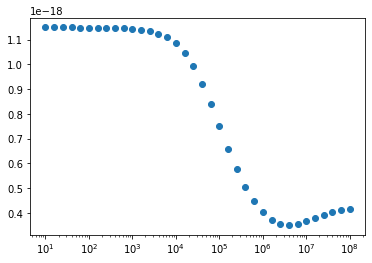

In [ ]:
plt.scatter(n0_values, chi_sqr_list)
plt.xscale("log")

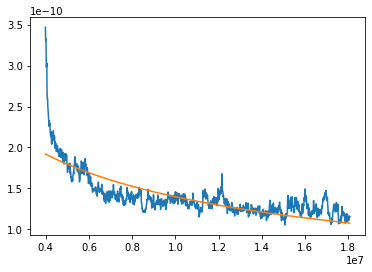

In [ ]:
plt.plot(result_list[best_idx][1], result_list[best_idx][2], label="data")
plt.plot(result_list[best_idx][1], result_list[best_idx][2] - result_list[best_idx][0].residual, label="residual")

In [ ]:
t = np.array([])
loss = np.array([])
for b in loss_list_b1:
    if b.angle==140.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

t, loss = take_from_peak(t, loss)

intensity = intensity_b1(t[0])

In [ ]:
result_list = []
n0_values = np.logspace(1, 8, 36) 

for n0 in tqdm(n0_values):
    try:
        result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
        result_list.append((result, turns, y))
    except Exception as e:
        print(e)
        print("Failed to fit data for n0 = {}".format(n0))
        result_list.append((None, None, None))

  0%|          | 0/36 [00:00<?, ?it/s]

431.17272627735895 0.018532793693516236 0
480.7886475349896 0.036842966534854193 0


In [ ]:
chi_sqr_list = []
for r in result_list:
    chi_sqr_list.append(r[0].chisqr)

best_idx = np.argmin(chi_sqr_list)

In [ ]:
result_list[best_idx][0].params

name,value,standard error,relative error,initial value,min,max,vary
rho,188.165057,7.09097448,(3.77%),100.0,0.00000000,inf,True
kappa,0.91135912,0.01020998,(1.12%),0.75,0.01000000,inf,True
a,0.00000000,0.00000000,,0,0.00000000,inf,False


In [ ]:
best_fits_b1 = best_fits_b1.append({
    "angle": 140.0,
    "rho": result_list[best_idx][0].params['rho'].value,
    "kappa": result_list[best_idx][0].params['kappa'].value,
    "n0": n0_values[best_idx],
    "chisq": chi_sqr_list[best_idx]
}, ignore_index=True)
    

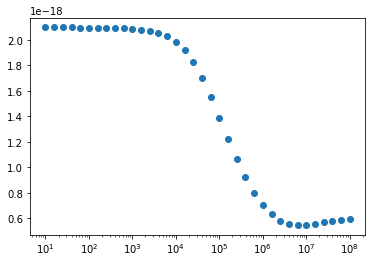

In [ ]:
plt.scatter(n0_values, chi_sqr_list)
plt.xscale("log")

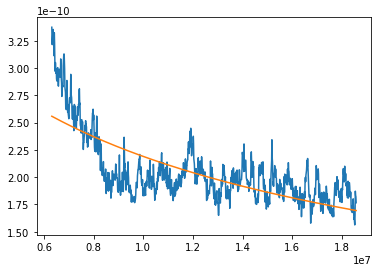

In [ ]:
plt.plot(result_list[best_idx][1], result_list[best_idx][2], label="data")
plt.plot(result_list[best_idx][1], result_list[best_idx][2] - result_list[best_idx][0].residual, label="residual")

In [ ]:
t = np.array([])
loss = np.array([])
for b in loss_list_b1:
    if b.angle==130.0:
        t = np.concatenate((t, b.loss_t))
        loss = np.concatenate((loss, b.loss))

t, loss = take_from_peak(t, loss)

intensity = intensity_b1(t[0])

In [ ]:
result_list = []
n0_values = np.logspace(1, 8, 36) 

for n0 in tqdm(n0_values):
    try:
        result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
        result_list.append((result, turns, y))
    except Exception as e:
        print(e)
        print("Failed to fit data for n0 = {}".format(n0))
        result_list.append((None, None, None))

  0%|          | 0/36 [00:00<?, ?it/s]

345.61231333446796 0.01872839088791589 0


In [ ]:
chi_sqr_list = []
for r in result_list:
    chi_sqr_list.append(r[0].chisqr)

best_idx = np.argmin(chi_sqr_list)

In [ ]:
result_list[best_idx][0].params

name,value,standard error,relative error,initial value,min,max,vary
rho,162.075026,1.01456069,(0.63%),100.0,0.00000000,inf,True
kappa,0.87428886,0.00167289,(0.19%),0.75,0.01000000,inf,True
a,0.00000000,0.00000000,,0,0.00000000,inf,False


In [ ]:
best_fits_b1 = best_fits_b1.append({
    "angle": 130.0,
    "rho": result_list[best_idx][0].params['rho'].value,
    "kappa": result_list[best_idx][0].params['kappa'].value,
    "n0": n0_values[best_idx],
    "chisq": chi_sqr_list[best_idx]
}, ignore_index=True)
    

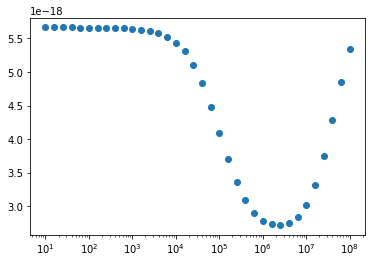

In [ ]:
plt.scatter(n0_values, chi_sqr_list)
plt.xscale("log")

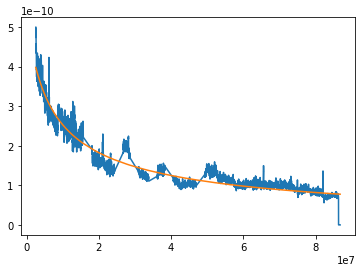

In [ ]:
plt.plot(result_list[best_idx][1], result_list[best_idx][2], label="data")
plt.plot(result_list[best_idx][1], result_list[best_idx][2] - result_list[best_idx][0].residual, label="residual")

In [ ]:
best_fits_b1

,angle,rho,kappa,n0,chisq
0,160.0,101.557635,0.743111,1.000000e+06,3.480297e-19
1,150.0,133.691622,0.810892,3.981072e+06,3.509398e-19
2,140.0,188.165057,0.911359,6.309573e+06,5.475482e-19
3,130.0,162.075026,0.874289,2.511886e+06,2.717761e-18


In [ ]:
for b in loss_list_b2:
    print("wire:", b.wire, "\toctupole:", b.octupole, " \tangle:", b.angle)

wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: False 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 160.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: False 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 150.0
wire: True 	octupole: True  	angle: 140.0
wire: False 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 140.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: False 	octupole: True  	angle: 130.0
wire: False 	octupole: False  	angle: 130.0
wire: True 	octupole: False  	angle: 130.0
wire: True 	octupole: True  	angle: 130.0
wire: False 	octupo

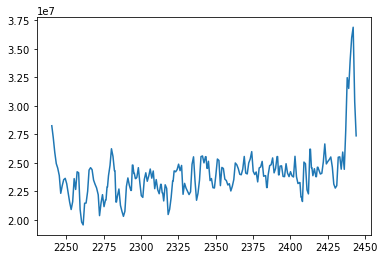

In [ ]:
plt.plot(loss_list_b2[3].loss_t, loss_list_b2[3].loss, label="b2")

In [ ]:
best_fits_b2 = pd.DataFrame(
    columns=["angle", "wire", "octupole", "rho", "kappa", "n0", "chisq"]
)
best_fits_b2

,angle,wire,octupole,rho,kappa,n0,chisq


In [50]:
result_main_list = []
n0_values = np.logspace(1, 8, 35) 

for angle in tqdm([160.0, 150.0, 140.0, 130.0]):
    t = np.array([])
    loss = np.array([])
    for b in loss_list_b1:
        if b.angle==angle:
            t = np.concatenate((t, b.loss_t))
            loss = np.concatenate((loss, b.loss))

    #t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

295.07500478961714 0.03119381192942372 0
1.386121127234861 0.04714018657110408 0


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

456.628004479397 0.039349681460729924 0
352.7248767588834 0.015426391904390435 0
435.0895812034771 0.014660264182803306 0


  0%|          | 0/35 [00:00<?, ?it/s]

355.6109376719208 0.015324293625522456 0


In [55]:
best_fits_3 = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits_3.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

In [56]:
best_fits_3

[{'lmfit': <lmfit.minimizer.MinimizerResult at 0x7f65b474a520>,
  'xdata': array([1.00000000e+02, 1.12325500e+04, 2.24888062e+04, 3.38799912e+04,
         4.51025012e+04, 5.62238062e+04, 6.75025412e+04, 7.87362850e+04,
         8.98800912e+04, 1.01271265e+05, 1.12527521e+05, 1.24514691e+05,
         1.35321136e+05, 1.46318735e+05, 1.57417550e+05, 1.68752521e+05,
         1.80188686e+05, 1.91231265e+05, 2.02420051e+05, 2.13934920e+05,
         2.25292370e+05, 2.36076336e+05, 2.47478766e+05, 2.58802470e+05,
         2.70013735e+05, 2.81247501e+05, 2.85082046e+05, 2.92852341e+05,
         2.96327046e+05, 3.03748735e+05, 3.15049971e+05, 3.26238735e+05,
         3.37596185e+05, 3.49234771e+05, 3.59940000e+05, 3.71308706e+05,
         3.82576185e+05, 3.93809951e+05, 4.05111176e+05, 4.16153766e+05,
         4.27387521e+05, 4.38632521e+05, 4.50259851e+05, 4.61122521e+05,
         4.65002046e+05, 4.72446236e+05, 4.76247046e+05, 4.83646256e+05,
         4.95048686e+05, 5.06046285e+05, 5.18415796

In [52]:
best_fits_3_b1 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_3_b1

,wire,angle,rho,kappa,n0,chisq,redchi


In [53]:
for d, b in zip(loss_list_b1, best_fits_3):
    best_fits_3_b1 = best_fits_3_b1.append({
        "wire": d.wire,
        "angle": d.angle,
        "rho": b["rho"],
        "kappa": b["kappa"],
        "n0": b["n0"],
        "chisq": b["chisq"],
        "redchi": b["redchi"]
    }, ignore_index=True)

In [54]:
best_fits_3_b1

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,71.057334,0.635713,10.0,8.229351e-20,4.546603e-22
1,False,160.0,71.057334,0.635713,10.0,8.229351e-20,4.546603e-22
2,False,160.0,71.057334,0.635713,10.0,8.229351e-20,4.546603e-22
3,False,160.0,71.057334,0.635713,10.0,8.229351e-20,4.546603e-22


In [ ]:
result_main_list = []
n0_values = np.logspace(2, 2, 1) 

for i, b in tqdm(enumerate(loss_list_b2[:-6]), total=len(loss_list_b2[:-6])):
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

In [ ]:
best_fits_2_b2 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_2_b2

,wire,angle,rho,kappa,n0,chisq,redchi


In [ ]:
for d, b in zip(loss_list_b2, best_fits):
    best_fits_2_b2 = best_fits_2_b2.append({
        "wire": d.wire,
        "angle": d.angle,
        "rho": b["rho"],
        "kappa": b["kappa"],
        "n0": b["n0"],
        "chisq": b["chisq"],
        "redchi": b["redchi"]
    }, ignore_index=True)

In [ ]:
best_fits_2_b2

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,96.319899,0.737146,100.0,1.637785e-18,2.225252e-21
1,True,160.0,111.403951,0.757123,100.0,2.761330e-19,4.341714e-22
2,False,160.0,73.325499,0.648397,100.0,3.325327e-19,1.187617e-21
3,True,160.0,93.034431,0.704750,100.0,1.354573e-19,5.967280e-22
4,True,150.0,94.899943,0.714182,100.0,9.914648e-20,5.665513e-22
5,False,150.0,54.724200,0.573988,100.0,2.347829e-19,1.514728e-21
6,True,150.0,102.150781,0.733771,100.0,2.140343e-19,6.080520e-22
7,False,150.0,61.811787,0.603654,100.0,2.358975e-19,1.008109e-21
8,True,150.0,92.887803,0.706400,100.0,1.656496e-19,6.157979e-22
9,True,140.0,86.617220,0.691429,100.0,7.579723e-20,4.538756e-22


In [ ]:
result_list = []
n0_values = np.logspace(1, 8, 36) 

for n0 in tqdm(n0_values):
    try:
        result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
        result_list.append((result, turns, y))
    except Exception as e:
        print(e)
        print("Failed to fit data for n0 = {}".format(n0))
        result_list.append((None, None, None))

  0%|          | 0/36 [00:00<?, ?it/s]

345.61231333446796 0.01872839088791589 0


In [40]:
result_main_list = []
n0_values = np.logspace(1, 8, 35) 

for i, b in tqdm(enumerate(loss_list_b2[:-6]), total=len(loss_list_b2[:-6])):
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b2(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

292.0617932515954 0.030543254354304272 0
383.36869060549833 0.010713526850904875 0
402.0626796436315 0.017727723704729748 0


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

2.459930733111355 0.04140961898589368 0
400.37930764408503 0.018679932945673272 0
313.80449172176947 0.02592719734092852 0
326.40202287544116 0.024780825654791228 0


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

3.023515939215196 0.04259005365219237 0
3.051823353282951 0.0434279559458044 0
3.0623365008587387 0.043746043914125954 0
3.066725992006659 0.04388002340570751 0
3.0683671818428895 0.04393028443505553 0
3.067382424595433 0.04390027573040789 0
281.33855287380015 0.03151089276232155 0
2.8087317004882104 0.04412207589855899 0
2.7588836310961193 0.04266370940781994 0
2.8387521301092846 0.044970885336337973 0
2.4937288195859546 0.04610967669474064 0
2.3700591162711437 0.04325333232003126 0
2.4294641629064384 0.044753259609070284 0
2.485943095186797 0.04610556649065467 0
369.0040224660663 0.010025422250254934 0
345.48478105979785 0.014380682428577263 0
485.8024565448904 0.037713109256716226 0


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

2.901146583180887 0.043877678138209086 0
2.829767377206567 0.041734537301963304 0
2.939052349484175 0.044940990335258446 0
2.9475525239990548 0.04519639668087416 0
2.9487828831885468 0.045233023197629896 0
322.3624737902344 0.014227958652269779 0
2.4529351104371555 0.04062267333844227 0
2.5634697561111257 0.04350786209523383 0
2.6562687497320336 0.04599715484631095 0
2.6642510079662727 0.04621504742249338 0


  0%|          | 0/35 [00:00<?, ?it/s]

444.84696034136886 0.023645527949573086 0


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

2.6571486531781536 0.04246222330723515 0
2.7552190377423185 0.04520725446463647 0
346.8754959350483 0.010242654977788979 0
2.2238933043724645 0.042357606484616506 0
2.321593250787879 0.045639819118790115 0
492.5058625217474 0.040707824373623636 0


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

2.1224837627137725 0.04665069846659553 0


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

2.7686330555032237 0.04574404451707359 0
2.7202476774874857 0.04436533536252463 0
2.777532031848202 0.04598818214046907 0
335.19313729989415 0.01212922722893861 0
2.3716176534229265 0.04751071852886213 0
2.330676295292272 0.04674026815631027 0
2.374849875548841 0.0476338896105295 0
2.374418091187736 0.047628292805345085 0


  0%|          | 0/35 [00:00<?, ?it/s]

292.9722129671628 0.030019756764484207 0
288.4322772848005 0.05096863844466171 0
446.6221022505067 0.019906728245800975 0


  0%|          | 0/35 [00:00<?, ?it/s]

282.22895945406003 0.03905619479656863 0
325.7821744233681 0.022267277610618752 0
379.08690556165044 0.010543562024781572 0
0.0 0.010000000000000009 0


In [41]:
best_fits_3 = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits_3.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

In [42]:
best_fits_3_b2 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_3_b2

,wire,angle,rho,kappa,n0,chisq,redchi


In [43]:
for d, b in zip(loss_list_b2, best_fits_3):
    best_fits_3_b2 = best_fits_3_b2.append({
        "wire": d.wire,
        "angle": d.angle,
        "rho": b["rho"],
        "kappa": b["kappa"],
        "n0": b["n0"],
        "chisq": b["chisq"],
        "redchi": b["redchi"]
    }, ignore_index=True)

In [44]:
best_fits_3_b2

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,1.050977e+02,0.760222,8.161401e+04,3.886797e-19,5.280974e-22
1,True,160.0,1.715305e+02,0.875035,2.253934e+06,3.891261e-20,6.118336e-23
2,False,160.0,9.029717e+01,0.707236,2.253934e+06,3.717233e-20,1.327583e-22
3,True,160.0,3.863706e+07,5.717430,6.224689e+07,2.390680e-20,1.053163e-22
4,True,150.0,1.247855e+02,0.787971,1.311134e+05,3.840707e-20,2.194690e-22
5,False,150.0,6.027338e+01,0.601200,5.436184e+05,2.508270e-20,1.618239e-22
6,True,150.0,1.954167e+02,0.911091,1.403004e+06,3.433713e-20,9.754866e-23
7,False,150.0,7.007642e+01,0.638588,8.733262e+05,3.218331e-20,1.375355e-22
8,True,150.0,1.655599e+02,0.862898,8.733262e+05,5.461531e-20,2.030309e-22
9,True,140.0,9.733091e+01,0.722379,5.080218e+04,4.431627e-20,2.653669e-22


In [45]:
result_main_list = []
n0_values = np.logspace(2, 2, 1) 

for i, b in tqdm(enumerate(loss_list_b2[:-6]), total=len(loss_list_b2[:-6])):
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx],
        "redchi": rm[best_idx][0].redchi
    })

In [47]:
best_fits_2_b2 = pd.DataFrame(
    columns=["wire", "angle", "rho", "kappa", "n0", "chisq", "redchi"]
)
best_fits_2_b2

,wire,angle,rho,kappa,n0,chisq,redchi


In [48]:
for d, b in zip(loss_list_b2, best_fits):
    best_fits_2_b2 = best_fits_2_b2.append({
        "wire": d.wire,
        "angle": d.angle,
        "rho": b["rho"],
        "kappa": b["kappa"],
        "n0": b["n0"],
        "chisq": b["chisq"],
        "redchi": b["redchi"]
    }, ignore_index=True)

In [49]:
best_fits_2_b2

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,96.319899,0.737146,100.0,1.637785e-18,2.225252e-21
1,True,160.0,111.403951,0.757123,100.0,2.761330e-19,4.341714e-22
2,False,160.0,73.325499,0.648397,100.0,3.325327e-19,1.187617e-21
3,True,160.0,93.034431,0.704750,100.0,1.354573e-19,5.967280e-22
4,True,150.0,94.899943,0.714182,100.0,9.914648e-20,5.665513e-22
5,False,150.0,54.724200,0.573988,100.0,2.347829e-19,1.514728e-21
6,True,150.0,102.150781,0.733771,100.0,2.140343e-19,6.080520e-22
7,False,150.0,61.811787,0.603654,100.0,2.358975e-19,1.008109e-21
8,True,150.0,92.887803,0.706400,100.0,1.656496e-19,6.157979e-22
9,True,140.0,86.617220,0.691429,100.0,7.579723e-20,4.538756e-22


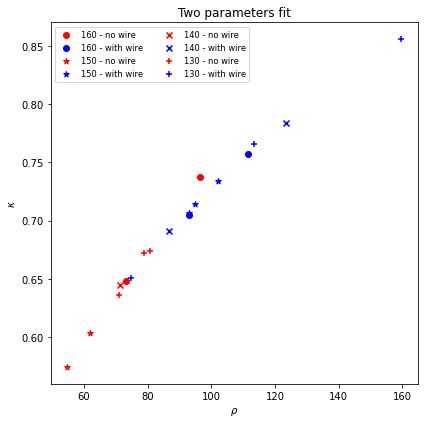

In [49]:
plt.figure(figsize=(6, 6))

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire")

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("Two parameters fit")

plt.tight_layout()

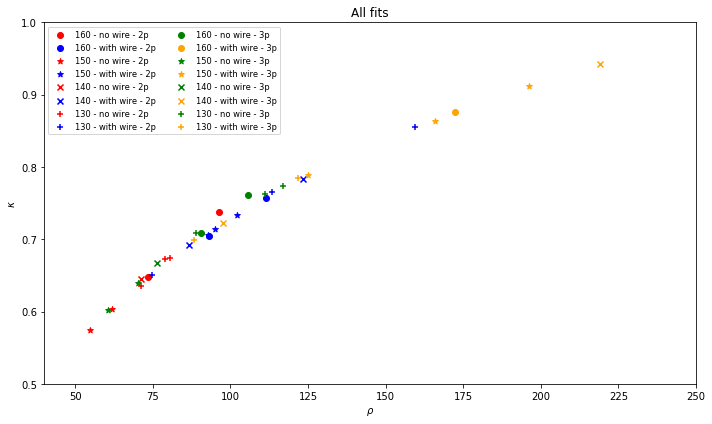

In [67]:
plt.figure(figsize=(10, 6))

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == False) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire - 2p")

tmp = best_fits_2_b2[(best_fits_2_b2["wire"] == True) & (best_fits_2_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire - 2p")

###############################################################################

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="o", label="160 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="o", label="160 - with wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="*", label="150 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="*", label="150 - with wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="x", label="140 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="x", label="140 - with wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="g", marker="+", label="130 - no wire - 3p")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="orange", marker="+", label="130 - with wire - 3p")

plt.xlim(40, 250)
plt.ylim(0.5, 1.0)

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("All fits")

plt.tight_layout()

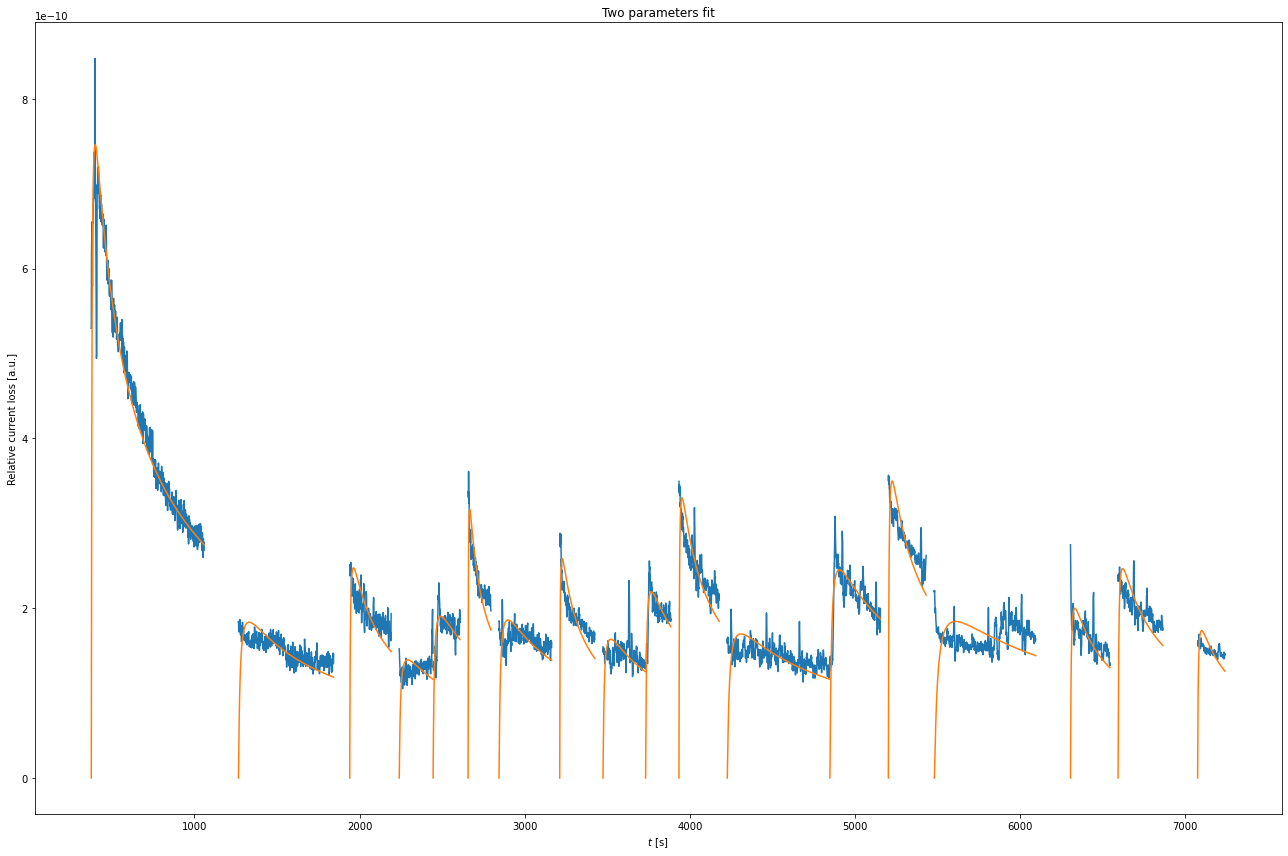

In [50]:
plt.figure(figsize=(18, 12))

for d, f in zip(loss_list_b2, best_fits):
    plt.plot(d.loss_t, f["ydata"], c="C0")
    plt.plot(d.loss_t, f["ydata"] - f['lmfit'].residual, c="C1")

plt.title("Two parameters fit")
plt.xlabel("$t$ [s]")
plt.ylabel("Relative current loss [a.u.]")
plt.tight_layout()

In [51]:
best_fits_3_b2

,wire,angle,rho,kappa,n0,chisq,redchi
0,False,160.0,1.055452e+02,0.761591,8.161401e+04,3.982884e-19,5.411527e-22
1,True,160.0,1.722526e+02,0.876373,2.253934e+06,3.976666e-20,6.252619e-23
2,False,160.0,9.061311e+01,0.708317,2.253934e+06,3.796829e-20,1.356010e-22
3,True,160.0,3.932637e+07,5.727177,6.224689e+07,2.438209e-20,1.074101e-22
4,True,150.0,1.251037e+02,0.788811,1.311134e+05,3.917628e-20,2.238645e-22
5,False,150.0,6.041678e+01,0.601943,5.436184e+05,2.558400e-20,1.650581e-22
6,True,150.0,1.960853e+02,0.912201,1.403004e+06,3.498938e-20,9.940164e-23
7,False,150.0,7.024592e+01,0.639340,8.733262e+05,3.277679e-20,1.400718e-22
8,True,150.0,1.660302e+02,0.863820,8.733262e+05,5.558752e-20,2.066451e-22
9,True,140.0,9.752571e+01,0.723035,5.080218e+04,4.507877e-20,2.699328e-22


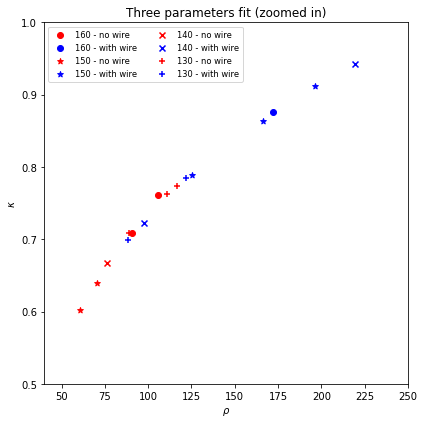

In [52]:
plt.figure(figsize=(6, 6))

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire")

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("Three parameters fit (zoomed in)")

#plt.xscale("log")
plt.xlim(40, 250)
plt.ylim(0.5, 1.0)
plt.tight_layout()

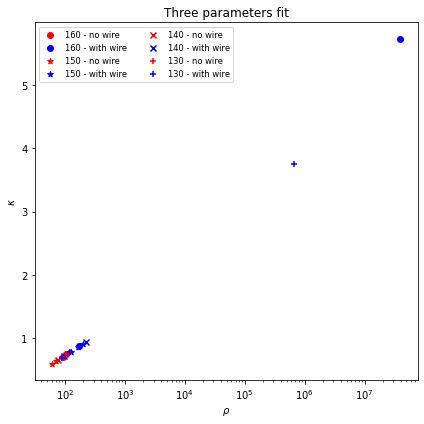

In [53]:
plt.figure(figsize=(6, 6))

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="o", label="160 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 160.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="o", label="160 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="*", label="150 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 150.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="*", label="150 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="x", label="140 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 140.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="x", label="140 - with wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == False) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="r", marker="+", label="130 - no wire")

tmp = best_fits_3_b2[(best_fits_3_b2["wire"] == True) & (best_fits_3_b2["angle"] == 130.0)]
plt.scatter(tmp["rho"], tmp["kappa"], c="b", marker="+", label="130 - with wire")

plt.legend(ncol=2, fontsize="small")
plt.xlabel("$\\rho$")
plt.ylabel("$\\kappa$")
plt.title("Three parameters fit")

plt.xscale("log")
# plt.xlim(right=1e3)
# plt.ylim(top=1.4)
plt.tight_layout()

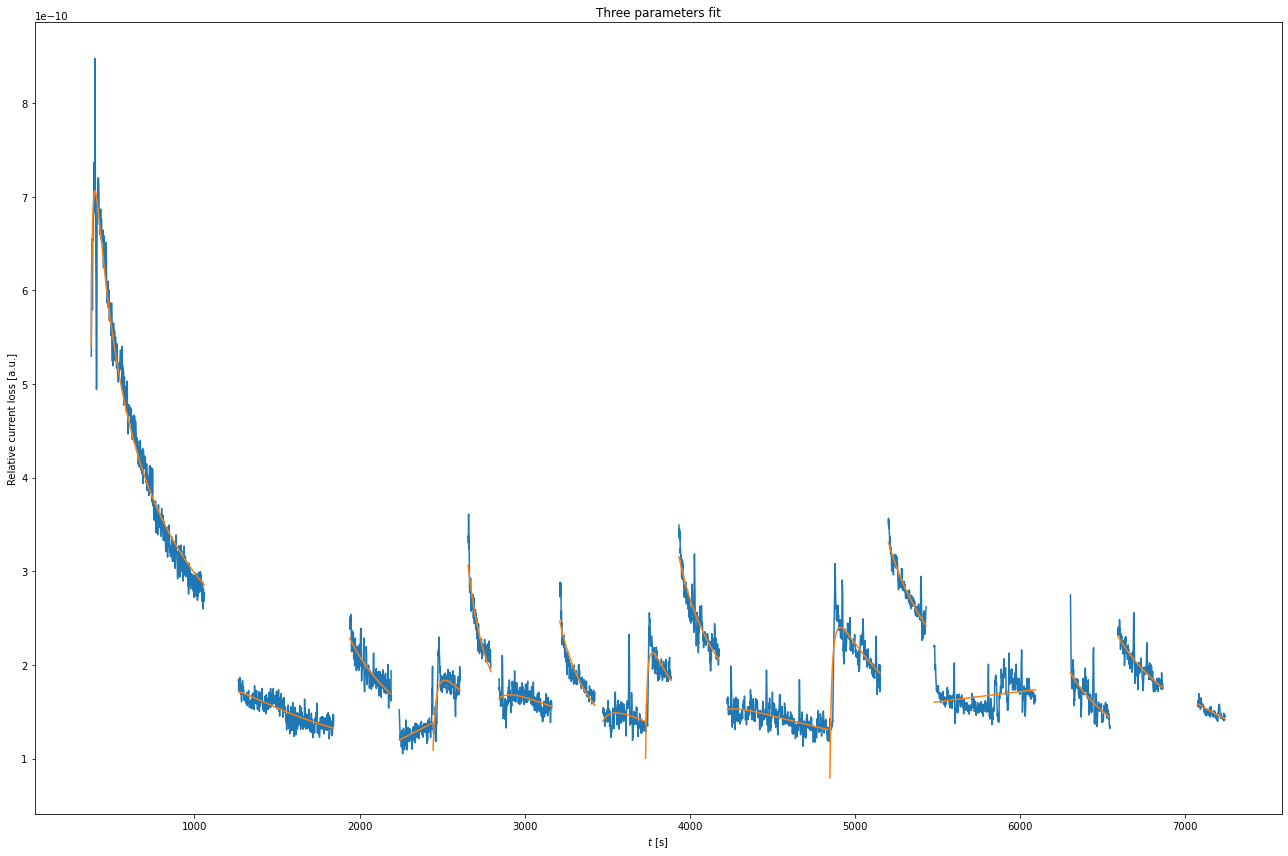

In [54]:
plt.figure(figsize=(18, 12))

for d, f in zip(loss_list_b2, best_fits_3):
    plt.plot(d.loss_t, f["ydata"], c="C0")
    plt.plot(d.loss_t, f["ydata"] - f['lmfit'].residual, c="C1")

plt.title("Three parameters fit")
plt.xlabel("$t$ [s]")
plt.ylabel("Relative current loss [a.u.]")
plt.tight_layout()

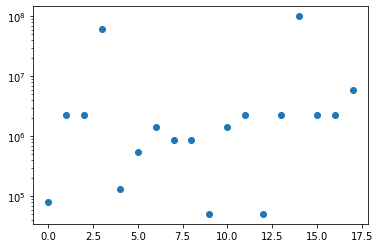

In [55]:
plt.plot(best_fits_3_b2.n0, "o")
plt.yscale("log")

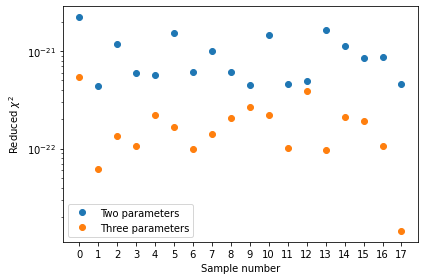

In [66]:
plt.plot(best_fits_2_b2.redchi, "o", label="Two parameters")
plt.plot(best_fits_3_b2.redchi, "o", label="Three parameters")

# set x-ticks as integers
plt.xticks(np.arange(0, len(best_fits_3_b2.n0), 1))

plt.yscale("log")
plt.xlabel("Sample number")
plt.ylabel("Reduced $\\chi^2$")
plt.legend()

plt.tight_layout()

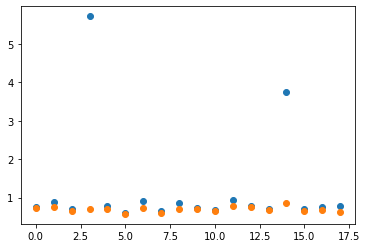

In [57]:
plt.plot(best_fits_3_b2.kappa, "o")
plt.plot(best_fits_2_b2.kappa, "o")

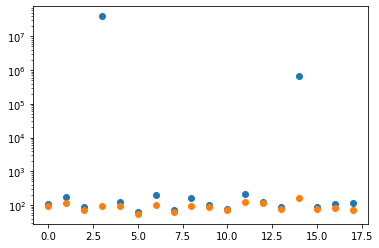

In [58]:
plt.plot(best_fits_3_b2.rho, "o")
plt.plot(best_fits_2_b2.rho, "o")
plt.yscale("log")


In [86]:
result_main_list = []
n0_values = np.logspace(1, 8, 20) 

for i, b in tqdm(enumerate(loss_list_b2[:4])):
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    if i <= 2:
        t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

484.5120282359738 0.043315737946713506 0
397.3367918341663 0.01927657354066814 0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

444.94496263957177 0.03241465704982782 0
467.93861055144805 0.03130372849997354 0


  0%|          | 0/20 [00:00<?, ?it/s]

0.0 0.010000000000000009 0


In [87]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

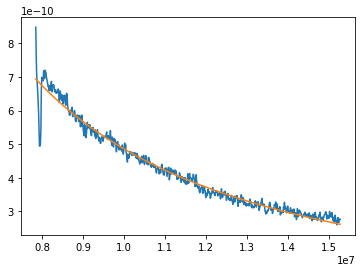

In [88]:
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'], label="data")
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'] - best_fits[0]['lmfit'].residual, label="residual")

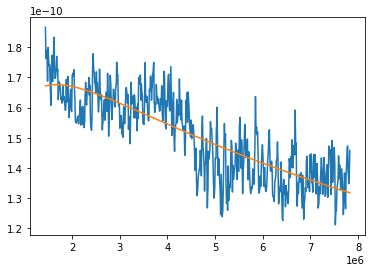

In [89]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

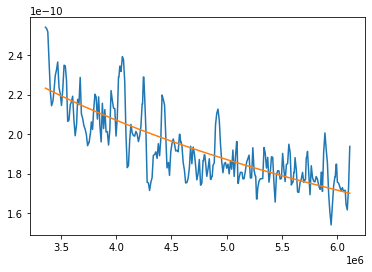

In [90]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

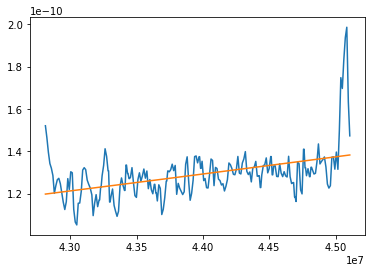

In [91]:
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'], label="data")
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'] - best_fits[3]['lmfit'].residual, label="residual")

In [94]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 542.4297734107073, kappa: 1.8181937188735249, n0: 7847599.703514607, chisq: 3.1521254813082085e-19
rho: 167.8189362023891, kappa: 0.8686184018384095, n0: 1438449.888287663, chisq: 3.92083047411488e-20
rho: 79.48589131492923, kappa: 0.6766873454107172, n0: 3359818.286283781, chisq: 3.560901956828893e-20
rho: 2385666.0743422327, kappa: 4.362459820915216, n0: 42813323.98719387, chisq: 2.4408100033167053e-20


In [102]:
result_main_list = []
n0_values = np.logspace(1, 2, 2) 

for i, b in tqdm(enumerate(loss_list_b2[:4])):
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [103]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

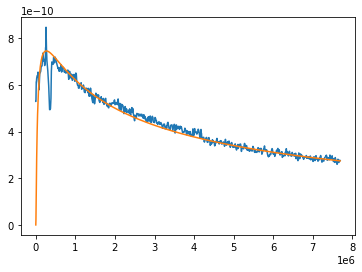

In [104]:
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'], label="data")
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'] - best_fits[0]['lmfit'].residual, label="residual")

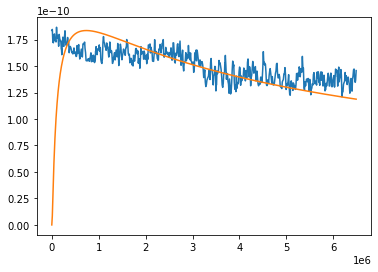

In [105]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

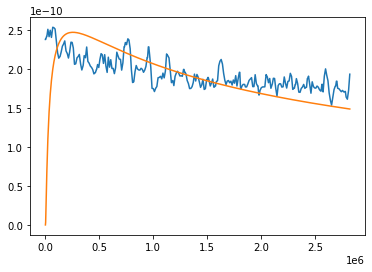

In [106]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

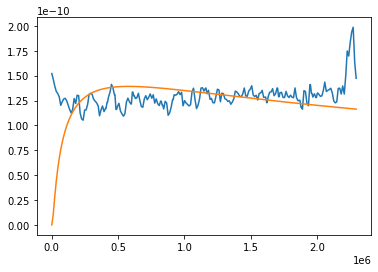

In [107]:
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'], label="data")
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'] - best_fits[3]['lmfit'].residual, label="residual")

In [108]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 96.3198990697615, kappa: 0.7371458440126675, n0: 100.0, chisq: 1.637785325549334e-18
rho: 111.40395130662523, kappa: 0.757123298999135, n0: 100.0, chisq: 2.76133001624119e-19
rho: 73.32549872491715, kappa: 0.6483973379240868, n0: 100.0, chisq: 3.3253271486410616e-19
rho: 93.03443066085084, kappa: 0.7047500960642243, n0: 100.0, chisq: 1.354572651122175e-19


In [186]:
result_main_list = []
n0_values = np.logspace(1, 8, 32) 

for i, b in tqdm(enumerate(loss_list_b2)):
    print(b.angle)
    if b.angle != 150.0:
        continue
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
        # t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

160.0
160.0
160.0
160.0
150.0


  0%|          | 0/32 [00:00<?, ?it/s]

150.0


  0%|          | 0/32 [00:00<?, ?it/s]

2.8063747442567655 0.03944014716986288 0
2.966701189367767 0.044113478057966615 0
2.97256479868999 0.044289919032248104 0
2.372949228867625 0.03767086629117666 0
2.6245687819791783 0.04418714906268706 0
2.6747016030368127 0.04555620285592332 0
457.87978420472155 0.032083613150478696 0
472.7343425050731 0.02915482488897192 0
150.0


  0%|          | 0/32 [00:00<?, ?it/s]

150.0


  0%|          | 0/32 [00:00<?, ?it/s]

2.7522962155593107 0.04414085530717582 0
2.660907869724804 0.041515804526304434 0
2.808262655662122 0.04567047769339516 0
2.800426944358195 0.045443394541394566 0
2.066462569157354 0.039250993993428906 0
2.3653333522281743 0.04676883379095442 0
2.3004968291903274 0.04554786154492141 0
2.367629069186024 0.046930220528828226 0
447.69825381393866 0.03702142382274487 0
150.0


  0%|          | 0/32 [00:00<?, ?it/s]

385.69287934147576 0.010070439885218274 0
140.0
140.0
140.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0


In [187]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

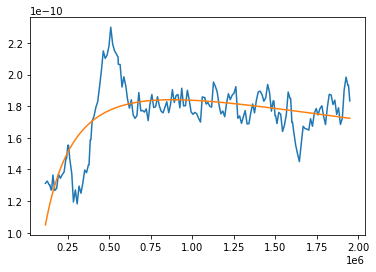

In [188]:
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'], label="data")
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'] - best_fits[0]['lmfit'].residual, label="residual")

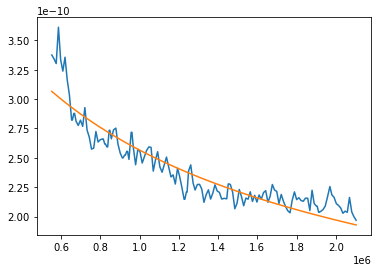

In [189]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

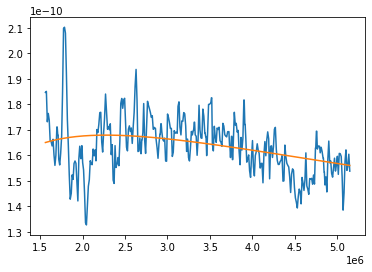

In [190]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

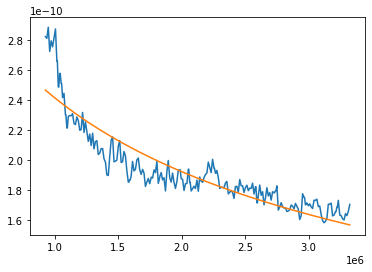

In [191]:
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'], label="data")
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'] - best_fits[3]['lmfit'].residual, label="residual")

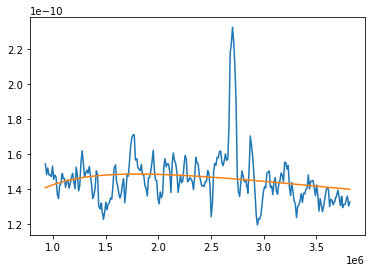

In [192]:
plt.plot(best_fits[4]['xdata'], best_fits[4]['ydata'], label="data")
plt.plot(best_fits[4]['xdata'], best_fits[4]['ydata'] - best_fits[4]['lmfit'].residual, label="residual")

In [193]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 121.97347983187862, kappa: 0.7819015467649293, n0: 116015.53017399715, chisq: 3.9398771009065056e-20
rho: 60.2041587514201, kappa: 0.6010924876735264, n0: 551995.4321281574, chisq: 2.558295749816276e-20
rho: 201.9917096453137, kappa: 0.9205300799619678, n0: 1561523.0060004964, chisq: 3.5100589463000684e-20
rho: 69.19383577844691, kappa: 0.6356763078082406, n0: 928414.5445194745, chisq: 3.2768692139158346e-20
rho: 168.9035747085244, kappa: 0.8685717139174809, n0: 928414.5445194745, chisq: 5.559912996875213e-20


In [120]:
result_main_list = []
n0_values = np.logspace(1, 2, 2) 

for i, b in tqdm(enumerate(loss_list_b2)):
    if b.angle != 150.0:
        continue

    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [121]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

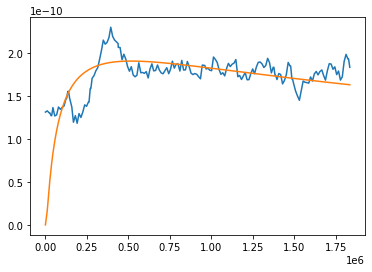

In [122]:
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'], label="data")
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'] - best_fits[0]['lmfit'].residual, label="residual")

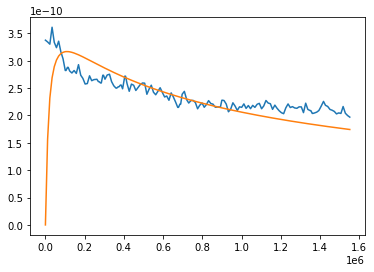

In [123]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

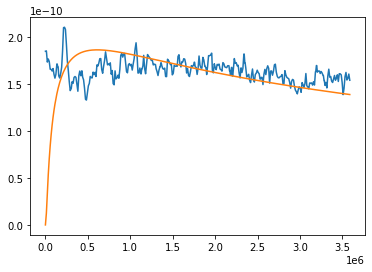

In [124]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

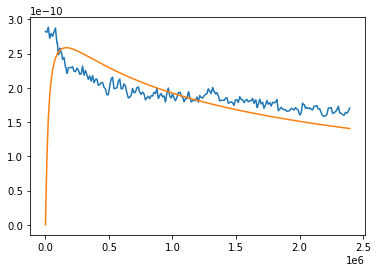

In [125]:
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'], label="data")
plt.plot(best_fits[3]['xdata'], best_fits[3]['ydata'] - best_fits[3]['lmfit'].residual, label="residual")

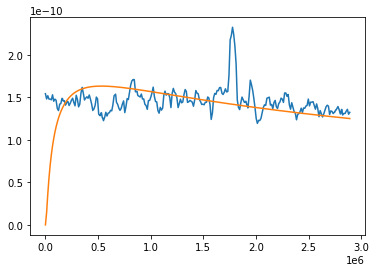

In [127]:
plt.plot(best_fits[4]['xdata'], best_fits[4]['ydata'], label="data")
plt.plot(best_fits[4]['xdata'], best_fits[4]['ydata'] - best_fits[4]['lmfit'].residual, label="residual")

In [128]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 94.89994316597571, kappa: 0.7141821481451622, n0: 100.0, chisq: 9.914648320783421e-20
rho: 54.724199932552125, kappa: 0.5739879483838697, n0: 100.0, chisq: 2.3478290198965693e-19
rho: 102.15078136759674, kappa: 0.7337713741330578, n0: 100.0, chisq: 2.1403431316461602e-19
rho: 61.811786983505925, kappa: 0.6036541440958354, n0: 100.0, chisq: 2.3589752394636615e-19
rho: 92.88780323894177, kappa: 0.7064000466701552, n0: 100.0, chisq: 1.6564962439383806e-19


In [129]:
result_main_list = []
n0_values = np.logspace(1, 8, 20) 

for i, b in tqdm(enumerate(loss_list_b2)):
    print(b.angle)
    if b.angle != 140.0:
        continue
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
        # t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

160.0
160.0
160.0
160.0
150.0
150.0
150.0
150.0
150.0
140.0


  0%|          | 0/20 [00:00<?, ?it/s]

140.0


  0%|          | 0/20 [00:00<?, ?it/s]

2.3484149615298033 0.04113037857109281 0
2.4670018580007476 0.04419796366828299 0
2.5123183651847625 0.04537051057631225 0
2.5304719080993934 0.04583329539692227 0
2.5377561184666906 0.0460172447756908 0
2.540686487442053 0.04609061519644064 0
338.5530356856737 0.0180078685330336 0
500.5429063203692 0.04647498705565822 0
140.0


  0%|          | 0/20 [00:00<?, ?it/s]

130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0
130.0


In [130]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

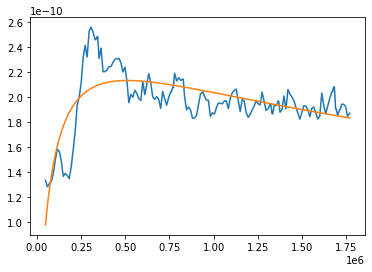

In [131]:
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'], label="data")
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'] - best_fits[0]['lmfit'].residual, label="residual")

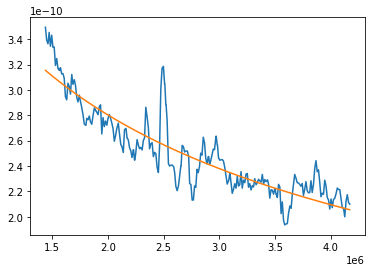

In [132]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

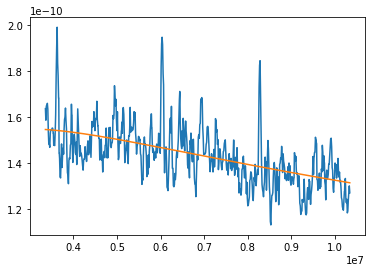

In [133]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

In [135]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 96.97687220330582, kappa: 0.721524283414372, n0: 48329.30238571752, chisq: 4.511091873074463e-20
rho: 75.47571968682442, kappa: 0.663795747364031, n0: 1438449.888287663, chisq: 5.859243087699001e-20
rho: 234.3529669283672, kappa: 0.9611643496737461, n0: 3359818.286283781, chisq: 7.061247862980519e-20


In [137]:
result_main_list = []
n0_values = np.logspace(1, 2, 2) 

for i, b in tqdm(enumerate(loss_list_b2)):
    if b.angle != 140.0:
        continue

    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [138]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

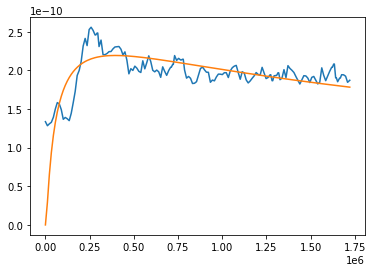

In [139]:
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'], label="data")
plt.plot(best_fits[0]['xdata'], best_fits[0]['ydata'] - best_fits[0]['lmfit'].residual, label="residual")

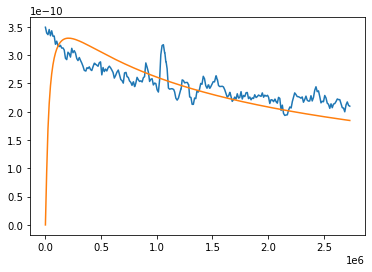

In [140]:
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'], label="data")
plt.plot(best_fits[1]['xdata'], best_fits[1]['ydata'] - best_fits[1]['lmfit'].residual, label="residual")

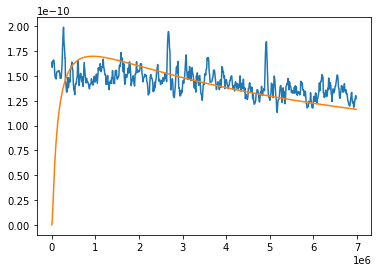

In [141]:
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'], label="data")
plt.plot(best_fits[2]['xdata'], best_fits[2]['ydata'] - best_fits[2]['lmfit'].residual, label="residual")

In [142]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 86.61722033498788, kappa: 0.6914292221093286, n0: 100.0, chisq: 7.579722691240112e-20
rho: 71.29160431626805, kappa: 0.6444967069810261, n0: 100.0, chisq: 3.9126339897530364e-19
rho: 123.40362992428469, kappa: 0.783943384520235, n0: 100.0, chisq: 3.153234330433537e-19


In [143]:
result_main_list = []
n0_values = np.logspace(1, 8, 20) 

for i, b in tqdm(enumerate(loss_list_b2)):
    print(b.angle)
    if b.angle != 130.0:
        continue
    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
        # t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

160.0
160.0
160.0
160.0
150.0
150.0
150.0
150.0
150.0
140.0
140.0
140.0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

130.0


  0%|          | 0/20 [00:00<?, ?it/s]

2.3699063540510705 0.044483405108117324 0
2.4143930938905656 0.04603335557219013 0
376.8274129771747 0.010184224017019128 0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

130.0


  0%|          | 0/20 [00:00<?, ?it/s]

130.0


  0%|          | 0/20 [00:00<?, ?it/s]

439.0917302547933 0.0284669172616423 0
462.1649783576289 0.027240370588724305 0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

394.01569860560824 0.01005900621252298 0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

2.565603551862638 0.045625472980884485 0
2.6393638052698245 0.0476034943459398 0
2.599116092110925 0.04655147328978915 0
2.646943524702788 0.04781887537665197 0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

2.414696238827145 0.046900454796861 0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

322.651849588685 0.015467057826009212 0
2.4602699564785846 0.0468621492298702 0
2.4889655752737947 0.047571390640660294 0
2.5006717444064037 0.04785415494015588 0
380.3151414142298 0.010144495245930418 0
0.0 0.010000000000000009 0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

125.64472117512541 0.03237098033260555 0
1.3195920221844335 0.04789363683424064 0
130.0


  0%|          | 0/20 [00:00<?, ?it/s]

130.0


  0%|          | 0/20 [00:00<?, ?it/s]

In [144]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

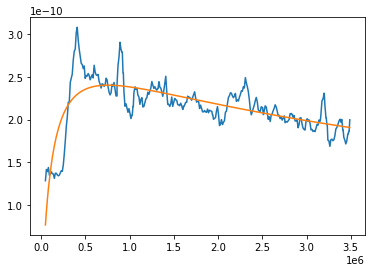

In [146]:
idx = 0
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

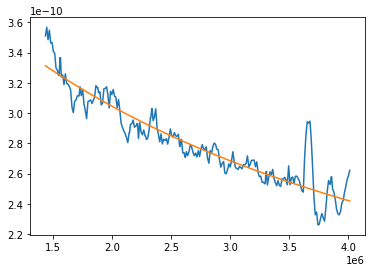

In [147]:
idx = 1
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

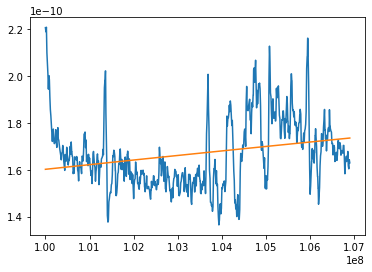

In [148]:
idx = 2
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

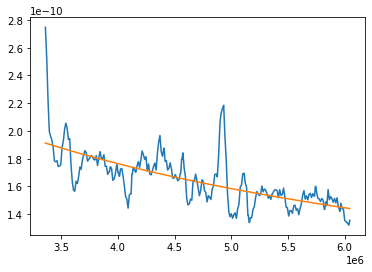

In [149]:
idx = 3
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

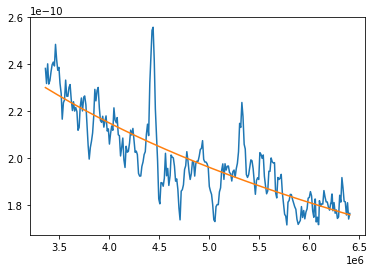

In [150]:
idx = 4
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

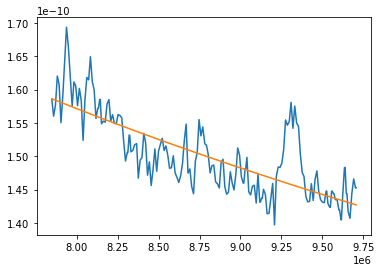

In [151]:
idx = 5
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

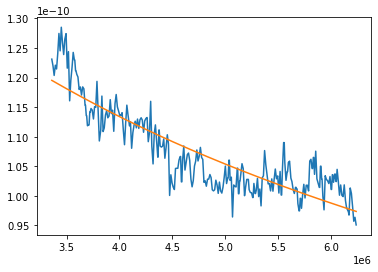

In [152]:
idx = 6
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

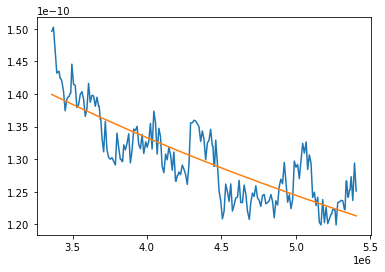

In [153]:
idx = 7
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

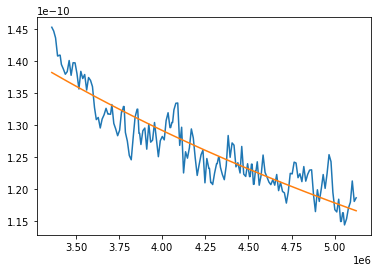

In [154]:
idx = 8
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

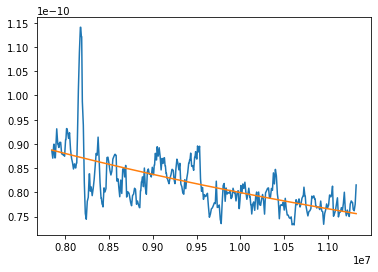

In [155]:
idx = 9
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

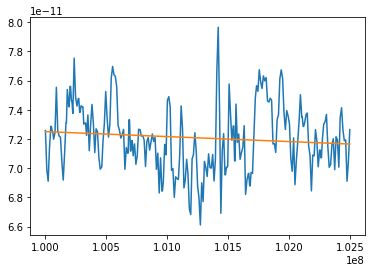

In [156]:
idx = 10
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

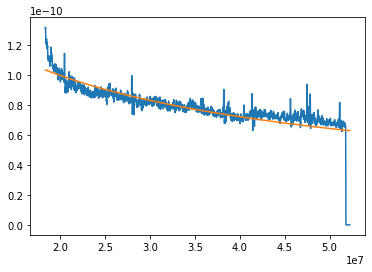

In [157]:
idx = 11
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

In [158]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 121.35121224666116, kappa: 0.7843034746272861, n0: 48329.30238571752, chisq: 1.3020844045007091e-19
rho: 105.05536952679896, kappa: 0.7513274352741739, n0: 1438449.888287663, chisq: 2.4551006560392855e-20
rho: 661716.979426786, kappa: 3.7434568623648667, n0: 100000000.0, chisq: 1.4678456069413391e-19
rho: 68.07703008261429, kappa: 0.6349390254507032, n0: 3359818.286283781, chisq: 5.065203742083471e-20
rho: 93.11524818060892, kappa: 0.7178515737318354, n0: 3359818.286283781, chisq: 2.958939578081299e-20
rho: 88.6392770869726, kappa: 0.7051832198774608, n0: 7847599.703514607, chisq: 2.602728474409143e-21
rho: 100.13013374105105, kappa: 0.7258741827610034, n0: 3359818.286283781, chisq: 3.4571897756104835e-21
rho: 113.22554117462855, kappa: 0.7606196406731172, n0: 3359818.286283781, chisq: 2.5940443279176974e-21
rho: 79.5801833475653, kappa: 0.6690269548367267, n0: 3359818.286283781, chisq: 1.2891234447560627e-21
rho: 93.3717415767412, kappa: 0.7079446425865952, n0: 7847599.703514607,

In [159]:
result_main_list = []
n0_values = np.logspace(1, 2, 2) 

for i, b in tqdm(enumerate(loss_list_b2)):
    if b.angle != 130.0:
        continue

    result_list = []
    t = np.array([])
    loss = np.array([])

    t = np.concatenate((t, b.loss_t))
    loss = np.concatenate((loss, b.loss))

    # if i <= 2:
    #     t, loss = take_from_peak(t, loss)

    intensity = intensity_b1(t[0])

    for n0 in tqdm(n0_values):
        try:
            result, turns, y = fit_data(t, loss, intensity, n0=n0, vary_a=False)
            result_list.append((result, turns, y))
        except Exception as e:
            print("Failed to fit data for n0 = {}".format(n0))
            result_list.append((None, None, None))
    
    result_main_list.append(result_list)

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [172]:
best_fits = []
for rm in result_main_list:
    chi_sqr_list = []
    for r in rm:
        chi_sqr_list.append(r[0].chisqr)

    best_idx = np.argmin(chi_sqr_list)
    best_fits.append({
        "lmfit": rm[best_idx][0],
        "xdata": rm[best_idx][1],
        "ydata": rm[best_idx][2],
        "resid": rm[best_idx][2] - rm[best_idx][0].residual,
        "rho": rm[best_idx][0].params['rho'].value,
        "kappa": rm[best_idx][0].params['kappa'].value,
        "n0": n0_values[best_idx],
        "chisq": chi_sqr_list[best_idx]
    })

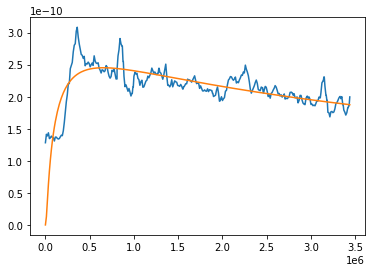

In [173]:
idx = 0
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

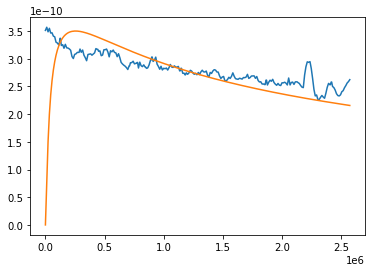

In [174]:
idx = 1
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

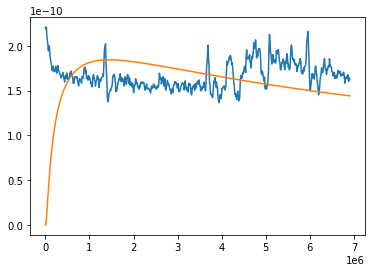

In [175]:
idx = 2
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

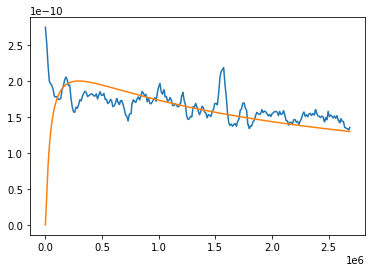

In [176]:
idx = 3
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

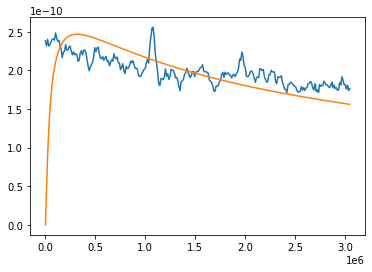

In [177]:
idx = 4
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

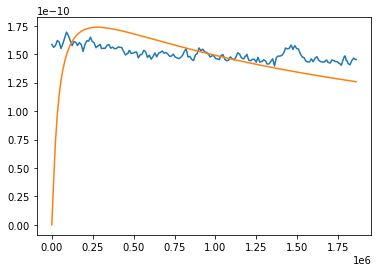

In [178]:
idx = 5
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

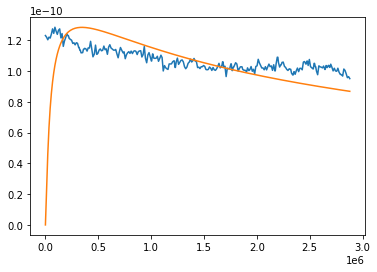

In [179]:
idx = 6
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

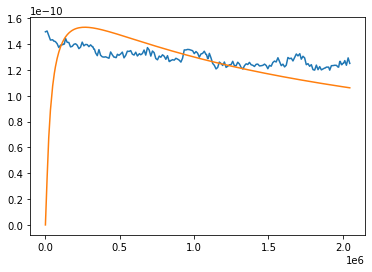

In [180]:
idx = 7
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

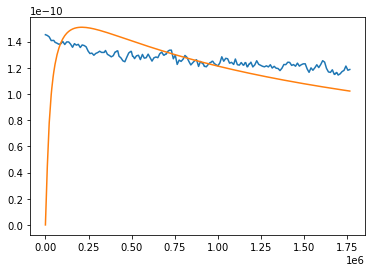

In [181]:
idx = 8
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

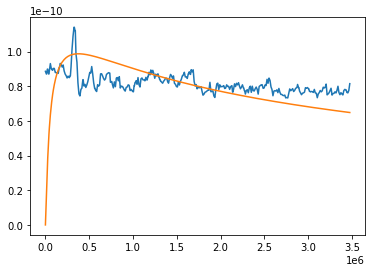

In [182]:
idx = 9
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

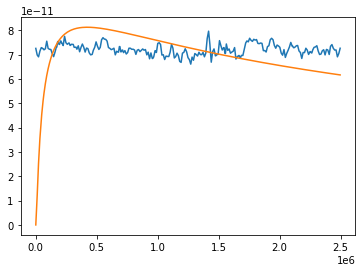

In [183]:
idx = 10
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

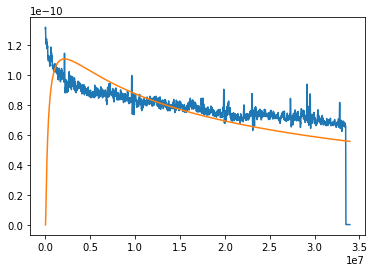

In [184]:
idx = 11
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'], label="data")
plt.plot(best_fits[idx]['xdata'], best_fits[idx]['ydata'] - best_fits[idx]['lmfit'].residual, label="residual")

In [185]:
for b in best_fits:
    print(f"rho: {b['rho']}, kappa: {b['kappa']}, n0: {b['n0']}, chisq: {b['chisq']}")

rho: 113.34609826559296, kappa: 0.7658773803619325, n0: 100.0, chisq: 1.655341364369342e-19
rho: 78.83936328234456, kappa: 0.6722114566454225, n0: 100.0, chisq: 4.15955164138031e-19
rho: 159.5249033396806, kappa: 0.855970874019752, n0: 100.0, chisq: 7.91315091450183e-19
rho: 74.7078736685443, kappa: 0.6507247333119981, n0: 100.0, chisq: 2.269267140037411e-19
rho: 80.6135825503912, kappa: 0.6736776937827873, n0: 100.0, chisq: 2.4093334541143525e-19
rho: 71.05733390707933, kappa: 0.6357130761970011, n0: 100.0, chisq: 8.229350567150241e-20
rho: 73.17640265122766, kappa: 0.6398618270725969, n0: 100.0, chisq: 6.315044450416474e-20
rho: 67.98683369528428, kappa: 0.6225514867281554, n0: 100.0, chisq: 7.446210226301423e-20
rho: 61.96323844884377, kappa: 0.5980174672508811, n0: 100.0, chisq: 5.952577443789137e-20
rho: 72.11636868724294, kappa: 0.632920390696317, n0: 100.0, chisq: 5.47763780005831e-20
rho: 72.77962419833428, kappa: 0.6330591068414324, n0: 100.0, chisq: 2.5183767090619115e-20
rho

In [66]:
def n0_resid(params, x, y):
    n0 = params['n0'].value
    rho = params['rho'].value
    kappa = params['kappa'].value

    model = wrap_4(x + np.power(10, n0), rho, kappa)
    
    model = model.real
    if np.isnan(model).any():
        print(n0, rho, kappa)
        return y + 1e10
    return y + model

def n0_subroutine(params, x, y):
    rho = params['rho'].value
    kappa = params['kappa'].value
    print(rho, kappa)
    n0_params = lmfit.Parameters()
    n0_params.add('n0', value=2, vary=False, min=1, max=2)
    n0_params.add('rho', value=rho, vary=False)
    n0_params.add('kappa', value=kappa, vary=False)

    n0_result = lmfit.minimize(n0_resid, n0_params, args=(x, y), method="leastsq")

    model = wrap_4(x + np.power(10, n0_result.params["n0"]), rho, kappa)

    # keep real part of model only
    model = model.real
    if np.isnan(model).any():
        print(n0, rho, kappa)
        return y + 1e10
    return y + model


def fit_data_v2(seconds, loss, intensity, method="leastsq", rho0=100.0, kappa0=0.75):
    # init parameters for lmfit
    params = lmfit.Parameters()
    params.add('rho', value=rho0, min=0)
    params.add('kappa', value=kappa0, min=0.01, max=1.0)

    # prepare the loss data
    turns = seconds * TURNS_PER_SECOND
    y = (loss / intensity) / TURNS_PER_SECOND

    # set the offset
    turns -= turns[0]
    turns += 10

    # fit the data
    result = lmfit.minimize(n0_subroutine, params, args=(turns, y), method=method)

    n0_params = lmfit.Parameters()
    n0_params.add('n0', value=2, vary=False, min=0, max=8)
    n0_params.add('rho', value=result.params["rho"].value, vary=False)
    n0_params.add('kappa', value=result.params["kappa"].value, vary=False)

    n0_result = lmfit.minimize(n0_resid, n0_params, args=(turns, y), method="leastsq")

    return n0_result, turns, y

In [67]:
b = loss_list_b2[0]

t = np.array([])
loss = np.array([])

t = np.concatenate((t, b.loss_t))
loss = np.concatenate((loss, b.loss))

intensity = intensity_b2(t[0])

result, turns, y = fit_data(t, loss, intensity, method="leastsq")

100.0 0.75 0
100.0 0.75 0
100.0 0.75 0
100.00000150486976 0.75 0
100.0 0.7500000173641348 0
100.0 0.75 0


In [68]:
result

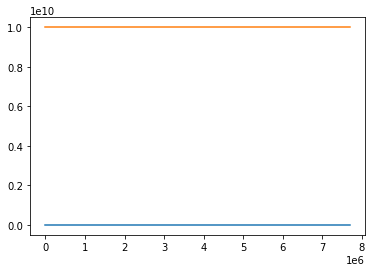

In [69]:
plt.plot(turns, y, label="data")
plt.plot(turns, y + result.residual, label="residual")